# MLP with word level embedding

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import torch 
import torch.nn.functional as F

In [2]:
papers = pd.read_csv("data/sci_papers.csv")

In [3]:
df = papers
counts = df["category"].value_counts()
categories = df.category.unique()
others = counts.index[5:].tolist()
df.loc[df['category'].isin(others), 'category'] = 'others'


In [4]:
titles = df["title"]

# Create a list of all unique words by splitting titles into words and using set
unique_words = set()
for title in titles:
    # Split each title into words and convert to lowercase
    words = ''.join(char.lower() for char in title if char.isalnum() or char.isspace()).split()
    unique_words.update(words)

# Convert set back to list for easier manipulation
vocab = sorted(list(unique_words))
len(vocab)

63800

Each word is embbeded with a emb_dim dimensional vector. 

The sentence is represented by a vector of size emb_dim, which is the coordonate by coordonate average of the word vectors.

The sentence vector is then passed to a MLP 


In [5]:
# each word is embbeded in a emb_dim dimension space
# So each title is embbeded as a list of word embeddings 
# As each title has a different length we will resort to pooling methods

categories = df.category.unique()

wtoi = {t:i for i,t in enumerate(vocab)} # word to integer 
itow = {i:t for i,t in enumerate(vocab)} # integer to word

ttoi = {t:i for i,t in enumerate(titles)} # title to integer 
itot = {i:t for i,t in enumerate(titles)} # integer to title

ctoi = {c:i for i,c in enumerate(categories)} # category to integer
itoc = {i:c for i,c in enumerate(categories)} # integer to category


In [6]:
emb_dim = 30
C = torch.randn((len(vocab), emb_dim))
C[0]

tensor([ 0.5984,  0.1166,  0.1474, -1.4299, -1.2299,  0.7995, -0.2101,  1.0011,
         0.2856,  0.5609,  0.3540, -0.6441, -0.3139, -0.3215, -0.6150, -1.6148,
         1.0987, -0.3125, -0.6247,  0.4219,  0.4466,  0.6026,  0.6409, -1.2917,
         0.5796,  0.4842, -1.5345,  1.3355,  0.1281, -0.1124])

In [7]:

emb_titles = []
for t in titles:
    t_clean = ''.join(char.lower() if char.isalnum() or char.isspace() else '' for char in t)
    words = t_clean.split()

    indices = [wtoi[w] for w in words if w in wtoi]
    word_embeddings = C[indices] # (nbr_words_in_title, emb_dim)
    avg_embedding = word_embeddings.mean(dim=0) # mean 
    
    emb_titles.append(avg_embedding)

emb_titles = torch.stack(emb_titles)
emb_titles.shape # (nbr_titles, emb_dim)

torch.Size([136238, 30])

In [8]:
def titles_embbeding(titles, C, poolingtype="avg"): 
    titles_emb = []
    for t in titles:
        t_clean = ''.join(char.lower() if char.isalnum() or char.isspace() else '' for char in t)
        words = t_clean.split()

        indices = [wtoi[w] for w in words if w in wtoi]
        word_embeddings = C[indices] # (nbr_words_in_title, emb_dim)
        if poolingtype == "avg":
            emb = word_embeddings.mean(dim=0) # mean 
        elif poolingtype == "max":
            emb = word_embeddings.max(dim=0)[0] # max values without the indices
        else:
            print("Choose between 'avg' and 'max'")
        titles_emb.append(emb)

    titles_emb = torch.stack(titles_emb)
    return titles_emb

batch_titles = [itot[i] for i in range(0,5)]
print(titles_embbeding(batch_titles, C, 'max'))

tensor([[ 0.4892, -0.1160,  0.4057, -0.2339,  1.5972, -0.4955,  1.2582,  0.6009,
          0.7813,  1.2922,  0.2636,  0.9465, -0.1051,  0.6341,  1.0112,  0.8859,
          0.9358,  1.1212,  0.1544,  1.3685,  1.5000,  0.7720,  0.3694,  0.8938,
          1.8073,  1.1475, -0.9158,  0.9014,  1.5687, -0.1373],
        [ 1.4358,  1.9464,  1.3814,  1.4350,  2.0493,  1.4671,  1.3956,  1.6979,
          1.6733,  0.7331,  1.9784,  2.2129,  1.2336,  1.3956,  1.3041,  1.6798,
          1.7837,  1.9201,  1.3204,  1.2998,  1.6435,  0.7375,  2.4869,  1.0048,
          2.0744,  3.0224,  2.0416,  2.1518,  1.1932,  1.6238],
        [-0.4978,  1.0530,  1.3915,  2.5195,  0.7615,  1.6854,  0.8927,  1.1467,
          0.4579,  0.6247,  1.3082,  0.6138,  0.9806,  1.6423,  1.5586,  0.8439,
          0.7094,  1.9113,  1.7967,  1.9683, -0.1149,  2.3054,  1.7074,  1.6535,
          1.5462,  1.8463,  0.8848,  0.8988,  2.9982,  0.8522],
        [ 1.2018,  1.8434,  1.1947,  1.6610,  3.0617,  1.1127,  1.1555,  1.3613

In [9]:
print(emb_titles[0])  # prints the embedding of the first title

t_clean = ''.join(char.lower() if char.isalnum() or char.isspace() else '' for char in titles[0])
words = t_clean.split()
word_embeddings = torch.stack([C[wtoi[w]] for w in words])
print(word_embeddings)  # prints embeddings of each word in the first title
print(torch.mean(word_embeddings, dim=0))  # prints the mean embedding across all words$

# we see that the mean pooling works
# In this simple example (2 words) we see that the embedded title is the coordinate-wise mean of the embedded words

# Now, we can train an MLP with the input beeing a title embbeding 

tensor([-0.1348, -0.5269, -0.2392, -0.3733,  0.4891, -1.1340,  0.5322,  0.2051,
         0.0089,  1.0585, -1.1755, -0.0537, -0.2156,  0.0857,  0.6751, -0.4259,
         0.2361,  0.3842, -0.5527, -0.1262,  0.3440,  0.0170, -1.0906, -0.0365,
         0.3032,  0.3486, -0.9186,  0.4938,  0.2902, -0.4918])
tensor([[ 0.4892, -0.1160,  0.4057, -0.5126,  1.5972, -0.4955, -0.1939,  0.6009,
         -0.7636,  0.8249, -2.6145,  0.9465, -0.1051,  0.6341,  0.3389, -1.7377,
          0.9358,  1.1212, -1.2598, -1.6209, -0.8120,  0.7720,  0.3694, -0.9667,
          1.8073,  1.1475, -0.9214,  0.0862, -0.9884, -0.1373],
        [-0.7589, -0.9379, -0.8842, -0.2339, -0.6191, -1.7726,  1.2582, -0.1908,
          0.7813,  1.2922,  0.2636, -1.0538, -0.3261, -0.4627,  1.0112,  0.8859,
         -0.4637, -0.3527,  0.1544,  1.3685,  1.5000, -0.7380, -2.5506,  0.8938,
         -1.2009, -0.4504, -0.9158,  0.9014,  1.5687, -0.8464]])
tensor([-0.1348, -0.5269, -0.2392, -0.3733,  0.4891, -1.1340,  0.5322,  0.2051,
  

In [93]:
def build_dataset(papers, n1, n2):
    X = [papers.iloc[i]["title"] for i in range(n1, n2)]
    Y = [ctoi[papers.iloc[i]["category"]] for i in range(n1, n2)]
    return X, Y

In [117]:
import random
random.seed(42)
indices = list(range(len(papers)))
random.shuffle(indices)
papers_shuffled = papers.iloc[indices].reset_index(drop=True) # shuffled dataset 
n1 = int(0.8*len(papers_shuffled))
n2 = int(0.9*len(papers_shuffled))
Xtr, Ytr = build_dataset(papers_shuffled, 0, n1)
Xdev, Ydev = build_dataset(papers_shuffled, n1, n2)
Xte, Yte = build_dataset(papers_shuffled, n2, len(papers_shuffled))

print(Xtr[:5])
print(Xdev[:5])
print(Xte[:5])

['Generalization Properties of Optimal Transport GANs with Latent\n  Distribution Learning', 'Exploring the Promise and Limits of Real-Time Recurrent Learning', 'Advancing multivariate time series similarity assessment: an integrated\n  computational approach', 'VRNet: Learning the Rectified Virtual Corresponding Points for 3D Point\n  Cloud Registration', 'LH-Mix: Local Hierarchy Correlation Guided Mixup over Hierarchical\n  Prompt Tuning']
['GeoFault: A well-founded fault ontology for interoperability in\n  geological modeling', 'SPARTan: Scalable PARAFAC2 for Large & Sparse Data', 'Query Learning Algorithm for Residual Symbolic Finite Automata', 'The slurk Interaction Server Framework: Better Data for Better Dialog\n  Models', 'Fast and Robust Multiple ColorChecker Detection using Deep Convolutional\n  Neural Networks']
['On the Convergence of Federated Averaging under Partial Participation\n  for Over-parameterized Neural Networks', 'Exploiting Multi-Label Correlation in Label Dist

In [50]:
titles = [itot[Xte[i].item()] for i in range(0, 5)]
cats = [itoc[Yte[i].item()] for i in range(0,5)]
print(titles)
print(cats)
print(papers_shuffled.iloc[ttoi["Simple Questions Generate Named Entity Recognition Datasets"]]["category"])

['AcTune: Uncertainty-aware Active Self-Training for Semi-Supervised\n  Active Learning with Pretrained Language Models', 'Harnessing Cross-lingual Features to Improve Cognate Detection for\n  Low-resource Languages', 'CrossSum: Beyond English-Centric Cross-Lingual Summarization for 1,500+\n  Language Pairs', 'Simple Questions Generate Named Entity Recognition Datasets', 'Khmer Word Search: Challenges, Solutions, and Semantic-Aware Search']
['Machine Learning', 'Machine Learning', 'Machine Learning', 'others', 'others']
others


In [148]:
nbr_added_layers = 1
nbr_neurons_hidden = [256 for _ in range(nbr_added_layers)]
nbr_neurons_first = 256
nbr_categories = len(categories)
nbr_titles = len(titles)
vocab_size = len(vocab)
emb_dim = 10

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size, emb_dim), generator=g)
W1 = torch.randn((emb_dim, nbr_neurons_first), generator=g) / nbr_neurons_first**0.5 # kaiming init
b1 = torch.randn(nbr_neurons_first, generator=g) * 0.1

Ws = []
bs = []
parameters = [C, W1, b1]
for i in range(0, nbr_added_layers):
    if i == 0:
        W = torch.randn((nbr_neurons_first, nbr_neurons_hidden[i]), generator=g) / nbr_neurons_hidden[i]**0.5
    else : 
        W = torch.randn((nbr_neurons_hidden[i], nbr_neurons_hidden[i]), generator=g) / nbr_neurons_hidden[i]**0.5
    
    b = torch.randn(nbr_neurons_hidden[i], generator=g) * 0.1
    parameters.append(W)
    parameters.append(b)
    Ws.append(W)
    bs.append(b)

Wlast = torch.randn((nbr_neurons_hidden[-1], nbr_categories), generator=g) / nbr_neurons_hidden[-1]**0.5
blast = torch.randn((nbr_categories), generator=g) * 0.1

parameters.append(Wlast)
parameters.append(blast)

for p in parameters:
    print(p.shape)

print(sum(p.nelement() for p in parameters))

torch.Size([63800, 10])
torch.Size([10, 256])
torch.Size([256])
torch.Size([256, 256])
torch.Size([256])
torch.Size([256, 6])
torch.Size([6])
708150


In [149]:
for p in parameters:
        p.requires_grad = True 
stepi, lossi, lri = [], [], []

In [176]:
epochs = 30
batch_size = 32
pooling_type = "avg"
lr = 0.1
max_it = 5000000

# Calculate number of batches per epoch
n_samples = len(Xtr)
n_batches = n_samples // batch_size

it_count = 0
for epoch in range(epochs):
    if it_count >= max_it:
        print(f'Max iterations reached: {max_it}')
        break
        
    # Shuffle training data at the beginning of each epoch
    indices = torch.randperm(n_samples)
    
    # Loop over batches
    for batch_idx in range(n_batches):
        # Get batch indices
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size
        batch_indices = indices[start_idx:end_idx]
        
        # Get the titles for these indices
        batch_titles = [Xtr[idx] for idx in batch_indices]
        batch_labels = torch.tensor([Ytr[idx] for idx in batch_indices])
        
        # Calculate embeddings for these titles using average pooling
        emb = titles_embbeding(batch_titles, C, pooling_type)
        
        # Forward pass through the network
        x = torch.tanh(emb @ W1 + b1)  
        for W, b in zip(Ws, bs): 
            x = torch.tanh(x @ W + b)
        logits = x @ Wlast + blast
        loss = F.cross_entropy(logits, batch_labels) 

        # Backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # Update parameters
        for p in parameters:
            p.data += -0.1 * p.grad 

        # Store metrics
        stepi.append(it_count)
        lossi.append(loss.item())
        
        it_count += 1
        if it_count >= max_it:
            break
            
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Iterations: {it_count}')


Epoch [10/30], Loss: 0.5332, Iterations: 34050
Epoch [20/30], Loss: 0.4260, Iterations: 68100
Epoch [30/30], Loss: 0.6555, Iterations: 102150


In [177]:
def deep_model_test(X,Y):
    # Stack all embeddings into a single tensor
    emb = titles_embbeding(X, C, pooling_type)
    batch_labels = torch.tensor(Y)
    
    # Forward pass through the network
    x = torch.tanh(emb @ W1 + b1)  
    for W, b in zip(Ws, bs): 
        x = torch.tanh(x @ W + b)
    logits = x @ Wlast + blast
    loss = F.cross_entropy(logits,torch.tensor(Y)) 


    return loss

ldev = deep_model_test(Xdev, Ydev)
ltest = deep_model_test(Xte, Yte)
ltrain = deep_model_test(Xtr, Ytr)
print("ltrain : ", ltrain)
print("dev : ", ldev)
print("test : ", ltest)

# with 60k iterations (avg_pooling, emb_dim = 10, 1 hidden layer, 256 neurons per layer)
#ltrain :  tensor(1.1399, grad_fn=<NllLossBackward0>)
#dev :  tensor(1.5250, grad_fn=<NllLossBackward0>)
#test :  tensor(1.5250, grad_fn=<NllLossBackward0>)
# and the loss isn't platauing 

# Same with max pooling : 
# ltrain : 1.1614
# dev :  1.7479
# test : 1.7479

ltrain :  tensor(0.4486, grad_fn=<NllLossBackward0>)
dev :  tensor(1.5948, grad_fn=<NllLossBackward0>)
test :  tensor(1.5960, grad_fn=<NllLossBackward0>)


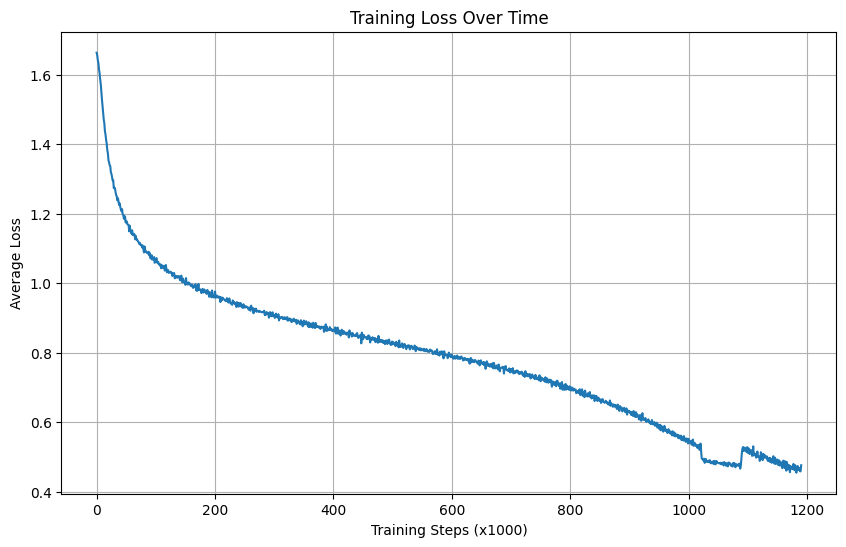

In [178]:
# Plot 1: Loss over training iterations (averaged over a window size)
window_size = 1000  # adjust this value to get smoother/rougher plot
plt.figure(figsize=(10, 6))
losses = torch.tensor(lossi)
n = len(losses)
n_windows = n // window_size
averaged_losses = losses[:n_windows * window_size].view(-1, window_size).mean(1)


plt.plot(averaged_losses)
plt.xlabel(f'Training Steps (x{window_size})')
plt.ylabel('Average Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

# Plot 2: Loss vs Learning Rate (averaged over 100 iterations)
# plt.figure()
# plt.plot(torch.tensor(lri).view(-1, 100).mean(1), torch.tensor(lossi).view(-1, 100).mean(1))
# plt.xlabel('Learning Rate')
# plt.ylabel('Average Loss')
# plt.title('Loss vs Learning Rate')
# plt.xscale('log')  # Learning rate is typically better viewed in log scale
# plt.grid(True)
# plt.show()

In [179]:
# forward
emb = titles_embbeding(Xte, C, pooling_type)

x = torch.tanh(emb @ W1 + b1)  
for W, b in zip(Ws, bs): 
    x = torch.tanh(x @ W + b)
logits = x @ Wlast + blast
probs = F.softmax(logits, dim=1)

# Display last 5 results
print("5 papers predictions:")
indices = torch.randint(0, len(papers_shuffled.iloc[n2:]), (5,))
for idx in indices:
    print("\nTitle:", papers_shuffled.iloc[n2:].iloc[idx.item()]['title'])
    print("True category:", papers_shuffled.iloc[n2:].iloc[idx.item()]['category'])
    print("\nPredicted probabilities:")
    # Sort probabilities in descending order and get corresponding categories
    sorted_probs = [(prob.item(), cat) for prob, cat in zip(probs[idx.item()], categories)]
    sorted_probs.sort(reverse=True)
    for prob, cat in sorted_probs:
        print(f"{cat}: {prob*100:.2f}%")

5 papers predictions:

Title: Recovering Accurate Labeling Information from Partially Valid Data for
  Effective Multi-Label Learning
True category: Machine Learning

Predicted probabilities:
Computation and Language (Natural Language Processing): 88.50%
Machine Learning: 8.26%
Artificial Intelligence: 2.63%
Computer Vision and Pattern Recognition: 0.51%
others: 0.05%
Machine Learning (Statistics): 0.04%

Title: Adaptive Best-of-Both-Worlds Algorithm for Heavy-Tailed Multi-Armed
  Bandits
True category: Machine Learning

Predicted probabilities:
Machine Learning: 66.14%
Machine Learning (Statistics): 32.84%
others: 0.63%
Artificial Intelligence: 0.36%
Computer Vision and Pattern Recognition: 0.02%
Computation and Language (Natural Language Processing): 0.00%

Title: Combat Models for RTS Games
True category: Artificial Intelligence

Predicted probabilities:
Artificial Intelligence: 72.63%
others: 13.73%
Machine Learning: 13.14%
Machine Learning (Statistics): 0.49%
Computation and Langu

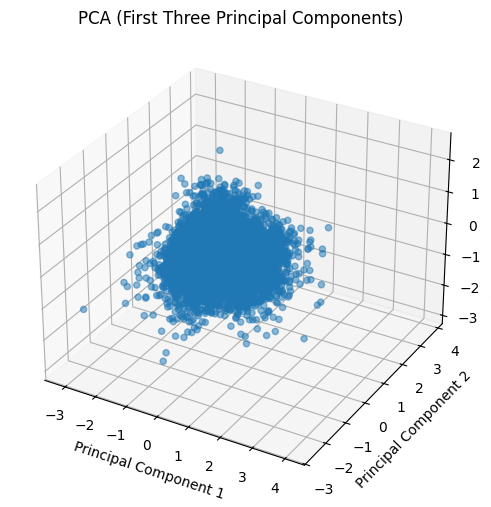

Composante 1: 21.36%
Composante 2: 18.28%
Composante 3: 12.46%
Composante 4: 9.60%
Composante 5: 8.48%
Composante 6: 6.78%
Composante 7: 6.35%
Composante 8: 5.96%
Composante 9: 5.70%
Composante 10: 5.05%


In [174]:
# We'll perform PCA by hand on the 'emb' tensor.
# 1. Detach the tensor and center the data
X = emb.detach()
X_centered = X - X.mean(dim=0)

# 2. Compute the covariance matrix (using Bessel's correction)
cov = (X_centered.t() @ X_centered) / (X_centered.shape[0] - 1)

# 3. Compute the eigenvalues and eigenvectors. Since the covariance matrix is symmetric, we can use torch.linalg.eigh.
eigenvalues, eigenvectors = torch.linalg.eigh(cov)

# 4. Sort the eigenvalues (and corresponding eigenvectors) in descending order
sorted_indices = torch.argsort(eigenvalues, descending=True)
top3_eigenvectors = eigenvectors[:, sorted_indices[:3]]

# 5. Project the centered data onto the top 2 eigenvectors (principal components)
proj = X_centered @ top3_eigenvectors

# 6. Plot the first three principal components in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(proj[:, 0].numpy(), proj[:, 1].numpy(), proj[:, 2].numpy(), alpha=0.5)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_title("PCA (First Three Principal Components)")
plt.show()

sorted_eigenvalues = eigenvalues[sorted_indices]
explained_variance_ratio = sorted_eigenvalues[:10] / sorted_eigenvalues.sum()
for i, ratio in enumerate(explained_variance_ratio, start=1):
    print(f"Composante {i}: {ratio.item() * 100:.2f}%")


Results for Training Set:
Accuracy: 0.8450


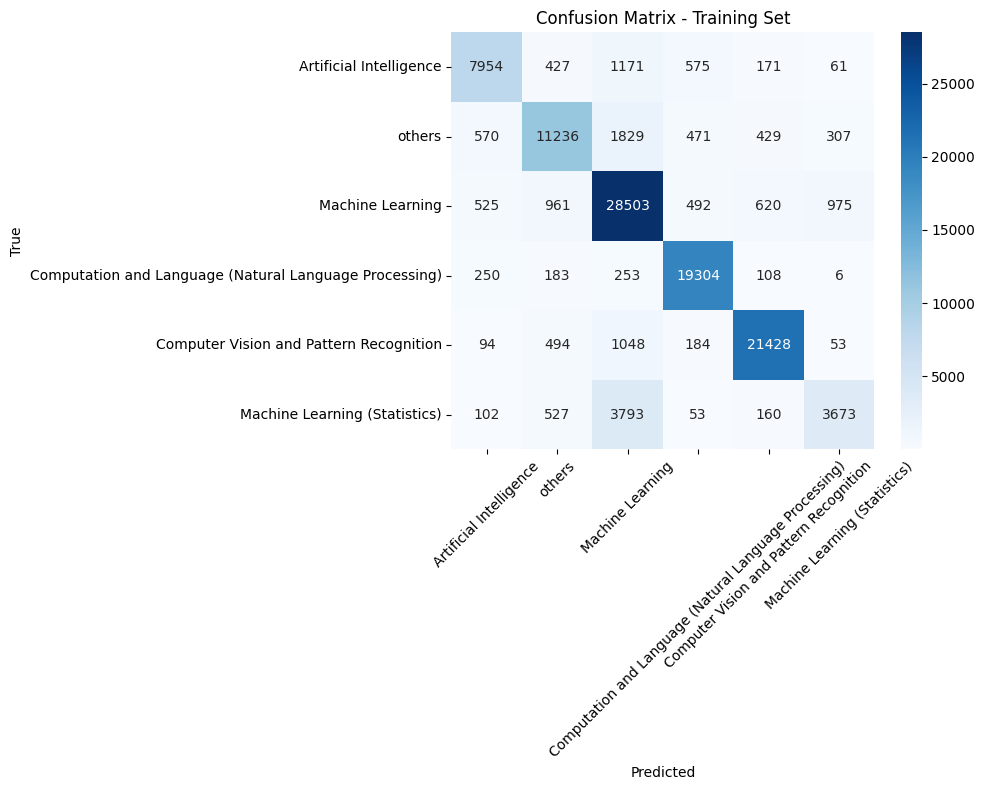


Classification Report:
                                                        precision    recall  f1-score   support

                               Artificial Intelligence       0.84      0.77      0.80     10359
                                                others       0.81      0.76      0.78     14842
                                      Machine Learning       0.78      0.89      0.83     32076
Computation and Language (Natural Language Processing)       0.92      0.96      0.94     20104
               Computer Vision and Pattern Recognition       0.94      0.92      0.93     23301
                         Machine Learning (Statistics)       0.72      0.44      0.55      8308

                                              accuracy                           0.85    108990
                                             macro avg       0.83      0.79      0.80    108990
                                          weighted avg       0.84      0.85      0.84    108990


Results for 

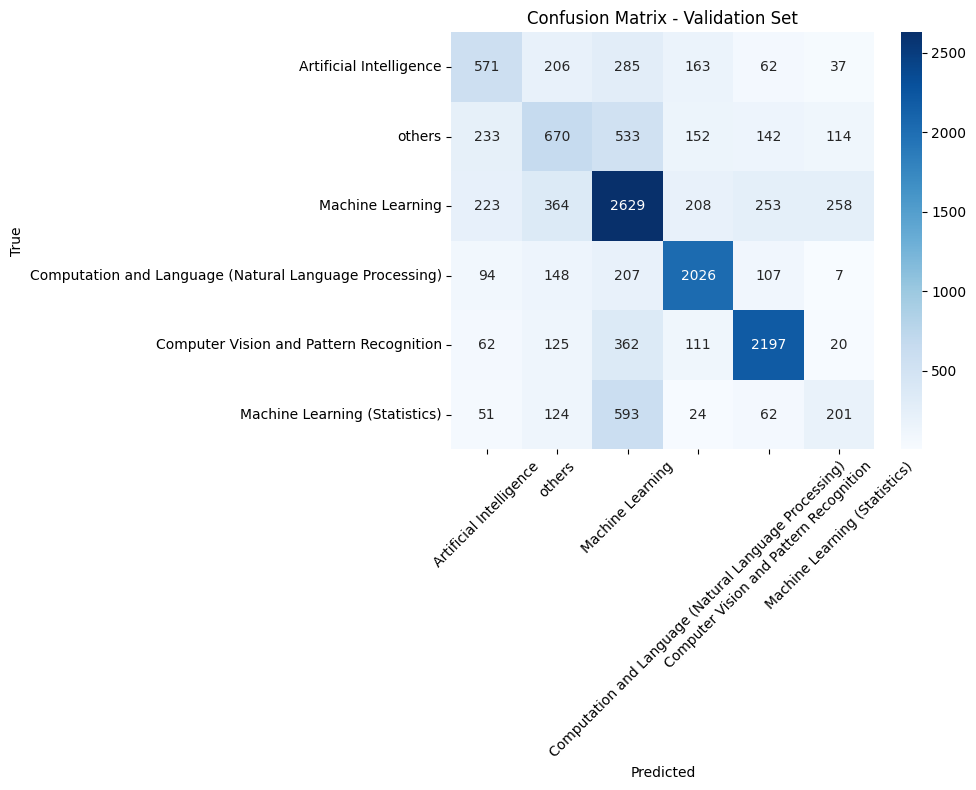


Classification Report:
                                                        precision    recall  f1-score   support

                               Artificial Intelligence       0.46      0.43      0.45      1324
                                                others       0.41      0.36      0.38      1844
                                      Machine Learning       0.57      0.67      0.62      3935
Computation and Language (Natural Language Processing)       0.75      0.78      0.77      2589
               Computer Vision and Pattern Recognition       0.78      0.76      0.77      2877
                         Machine Learning (Statistics)       0.32      0.19      0.24      1055

                                              accuracy                           0.61     13624
                                             macro avg       0.55      0.53      0.54     13624
                                          weighted avg       0.60      0.61      0.60     13624


Results for 

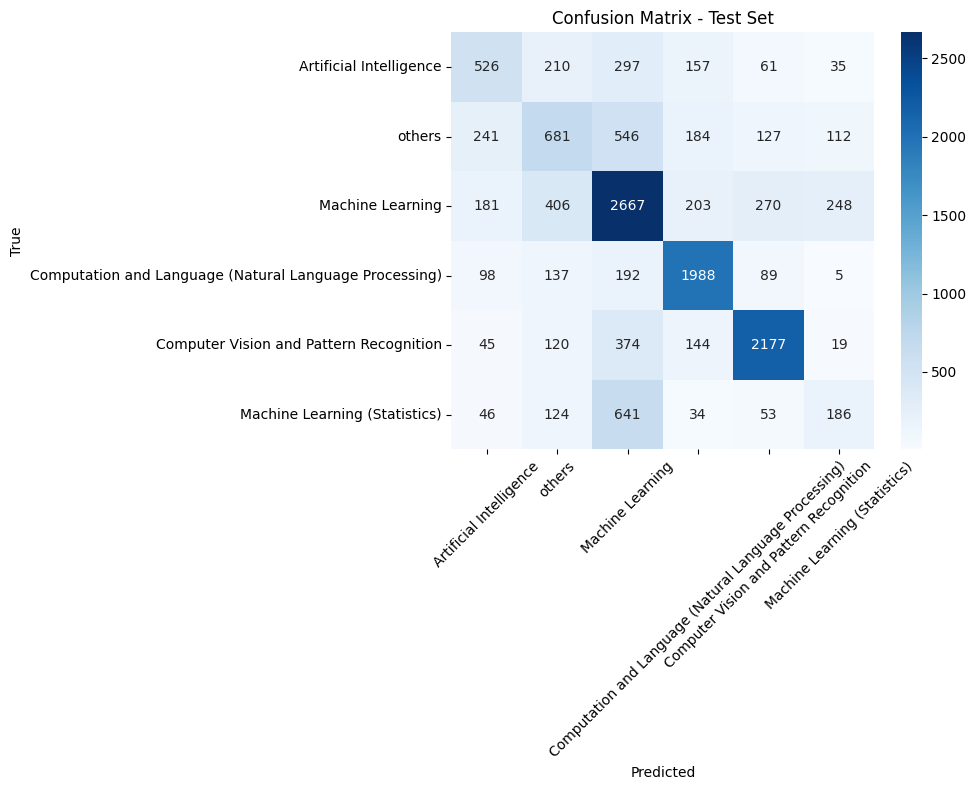


Classification Report:
                                                        precision    recall  f1-score   support

                               Artificial Intelligence       0.46      0.41      0.43      1286
                                                others       0.41      0.36      0.38      1891
                                      Machine Learning       0.57      0.67      0.61      3975
Computation and Language (Natural Language Processing)       0.73      0.79      0.76      2509
               Computer Vision and Pattern Recognition       0.78      0.76      0.77      2879
                         Machine Learning (Statistics)       0.31      0.17      0.22      1084

                                              accuracy                           0.60     13624
                                             macro avg       0.54      0.53      0.53     13624
                                          weighted avg       0.59      0.60      0.59     13624



In [180]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Import additional metrics

def evaluate_model(X, Y, split_name=""):
    # Forward pass
    emb = titles_embbeding(X, C, pooling_type)
    x = torch.tanh(emb @ W1 + b1)  
    for W, b in zip(Ws, bs): 
        x = torch.tanh(x @ W + b)
    logits = x @ Wlast + blast
    probs = F.softmax(logits, dim=1)
    
    # Get predictions
    predictions = torch.argmax(probs, dim=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(Y, predictions.numpy())
    
    # Create confusion matrix
    cm = confusion_matrix(Y, predictions.numpy())
    
    # Print results
    print(f"\nResults for {split_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[itoc[i] for i in range(len(categories))],
                yticklabels=[itoc[i] for i in range(len(categories))])
    plt.title(f'Confusion Matrix - {split_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(Y, predictions.numpy(), 
                              target_names=[itoc[i] for i in range(len(categories))]))
    
    return accuracy, predictions

# Evaluate on all splits
train_acc, train_preds = evaluate_model(Xtr, Ytr, "Training Set")
val_acc, val_preds = evaluate_model(Xdev, Ydev, "Validation Set")
test_acc, test_preds = evaluate_model(Xte, Yte, "Test Set")

There is a total of 18577 papers that are not in the first 5 main categories
and there are 117661 papers in the first 6 categories

 category
Machine Learning                                          39986
Computer Vision and Pattern Recognition                   29057
Computation and Language (Natural Language Processing)    25202
others                                                    18577
Artificial Intelligence                                   12969
Machine Learning (Statistics)                             10447
Name: count, dtype: int64


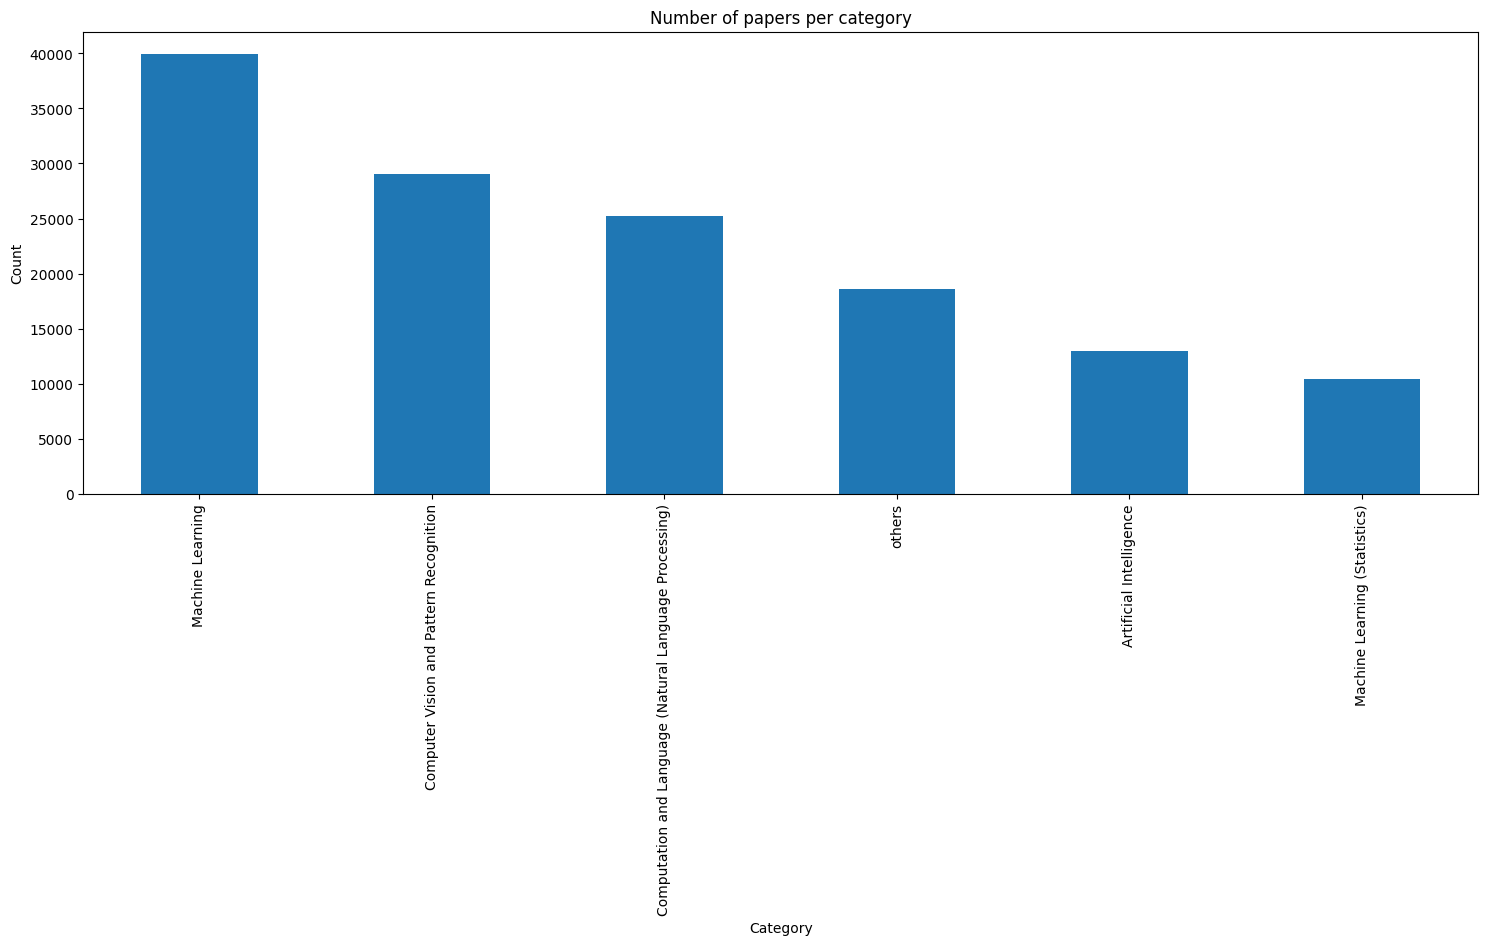

In [79]:
df = papers
categories = df.category.unique()
others = counts.index[5:].tolist()


# Modification of the values in "category"
df.loc[df['category'].isin(others), 'category'] = 'others'
print("There is a total of %d papers that are not in the first 5 main categories" % ((df['category'] == 'others').sum()))
print("and there are %d papers in the first 6 categories" % ((df['category'] != 'others').sum()))

print("\n", df.category.value_counts())

# Now, the distribution is more balanced
plt.figure(figsize=(12,6))
df.category.value_counts().plot(kind='bar')
plt.gcf().set_size_inches(18, 6)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Number of papers per category')
plt.xticks(rotation=90)
plt.show()

### Conclusion : 

We beat the title embedding model without any optimization and with a smaller model. 

Best result so far : 
- ltrain :  0.6415
- dev : 0.7594
- test : 0.7594

with the following hyperparameters :
- emb_dim : 10
- added hidden layer : 1
- hidden layer size : 100
- learning rate : 0.1 and 0.01 in the last 10%
- batch size : 32
- 1M iterations